In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

In [3]:
Exter_dict = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
Lot_dict = {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
Bsmt_dict = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
Bsmt_ex_dict = {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
Func_dict = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 
             'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}
Fence_dict = {'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

train['Exter Qual'].replace(Exter_dict, inplace = True)
test['Exter Qual'].replace(Exter_dict, inplace = True)

train['Exter Cond'].replace(Exter_dict, inplace = True)
test['Exter Cond'].replace(Exter_dict, inplace = True)

train['Heating QC'].replace(Exter_dict, inplace = True)
test['Heating QC'].replace(Exter_dict, inplace = True)

train['Kitchen Qual'].replace(Exter_dict, inplace = True)
test['Kitchen Qual'].replace(Exter_dict, inplace = True)

train['Bsmt Qual'].replace(Bsmt_dict, inplace = True)
test['Bsmt Qual'].replace(Bsmt_dict, inplace = True)

train['Bsmt Cond'].replace(Bsmt_dict, inplace = True)
test['Bsmt Cond'].replace(Bsmt_dict, inplace = True)

train['Bsmt Exposure'].replace(Bsmt_ex_dict, inplace = True)
test['Bsmt Exposure'].replace(Bsmt_ex_dict, inplace = True)

train['Functional'].replace(Func_dict, inplace = True)
test['Functional'].replace(Func_dict, inplace = True)

train['Fireplace Qu'].replace(Bsmt_dict, inplace = True)
test['Fireplace Qu'].replace(Bsmt_dict, inplace = True)

train['Garage Qual'].replace(Bsmt_dict, inplace = True)
test['Garage Qual'].replace(Bsmt_dict, inplace = True)

train['Garage Cond'].replace(Bsmt_dict, inplace = True)
test['Garage Cond'].replace(Bsmt_dict, inplace = True)

train['Pool QC'].replace(Bsmt_dict, inplace = True)
test['Pool QC'].replace(Bsmt_dict, inplace = True)

train['Fence'].replace(Fence_dict, inplace = True)
test['Fence'].replace(Fence_dict, inplace = True)

train['Lot Shape'].replace(Lot_dict, inplace = True)
test['Lot Shape'].replace(Lot_dict, inplace = True)



In [5]:
dummy_vars = ['Exterior 1st','House Style', 'Central Air', 'Foundation', 'MS Zoning', 'Street', 'Alley', 'Neighborhood']

In [6]:
train = pd.get_dummies(train, columns = dummy_vars)
test = pd.get_dummies(test, columns = dummy_vars)

In [7]:
train['Garage_Total'] = train['Garage Yr Blt'] * train['Garage Cars'] * train['Garage Area'] * train['Garage Qual'] * train['Garage Cond']
test['Garage_Total'] = train['Garage Yr Blt'] * train['Garage Cars'] * train['Garage Area'] * train['Garage Qual'] * train['Garage Cond']

In [8]:
train['Bsmt_Total'] = train['Bsmt Qual'] * train['Bsmt Cond'] * train['Bsmt Exposure'] * train['Total Bsmt SF']
test['Bsmt_Total'] = train['Bsmt Qual'] * train['Bsmt Cond'] * train['Bsmt Exposure'] * train['Total Bsmt SF']


In [9]:
train['TotRms_GrLiv'] = train['TotRms AbvGrd'] * train['Gr Liv Area']
test['TotRms_GrLiv'] = test['TotRms AbvGrd'] * test['Gr Liv Area']

In [10]:
train['id_yrsld'] = train['Id'] * train['Yr Sold']
test['id_yrsld'] = test['Id'] * test['Yr Sold']

In [11]:
train['Exter_Overall'] = train['Exter Qual'] * train['Overall Qual']
test['Exter_Overall'] = test['Exter Qual'] * test['Overall Qual']

In [12]:
#Notice how I did it to test, not train
features_init = [c for c in test._get_numeric_data().columns if not c in ['SalePrice']]

In [13]:
#Had to remove all the NaNs for this experiment
for n in features_init:
    if n in train.columns:
        train[n].fillna(0, inplace = True)
    if n in test.columns:
        test[n].fillna(0, inplace = True)


In [14]:
features_init.remove("Exterior 1st_PreCast")
#Some of the dummy variables only appeared in test, not train, so I had to remove it to keep consistency

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [18]:
train.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Garage_Total,Bsmt_Total,TotRms_GrLiv,id_yrsld,Exter_Overall
0,109,533352170,60,0.0,13517,2,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,16894800.0,6525.0,8874,219090,18
1,544,531379050,60,43.0,11492,2,Lvl,AllPub,CulDSac,Gtl,...,1,0,0,0,0,20093814.0,10956.0,16976,1092896,21
2,153,535304180,20,68.0,7922,3,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4323942.0,9513.0,5285,307530,10
3,318,916386060,60,73.0,9802,3,Lvl,AllPub,Inside,Gtl,...,0,0,0,1,0,14450400.0,4608.0,10108,639180,10
4,255,906425045,50,82.0,14235,2,Lvl,AllPub,Inside,Gtl,...,1,0,0,0,0,17049384.0,5408.0,8670,512550,12


In [19]:
train[features_init].head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Lot Shape,Overall Qual,Overall Cond,Year Built,Year Remod/Add,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Garage_Total,Bsmt_Total,TotRms_GrLiv,id_yrsld,Exter_Overall
0,109,533352170,60,0.0,13517,2,6,8,1976,2005,...,0,0,0,0,0,16894800.0,6525.0,8874,219090,18
1,544,531379050,60,43.0,11492,2,7,5,1996,1997,...,1,0,0,0,0,20093814.0,10956.0,16976,1092896,21
2,153,535304180,20,68.0,7922,3,5,7,1953,2007,...,0,0,0,0,0,4323942.0,9513.0,5285,307530,10
3,318,916386060,60,73.0,9802,3,5,5,2006,2007,...,0,0,0,1,0,14450400.0,4608.0,10108,639180,10
4,255,906425045,50,82.0,14235,2,6,8,1900,1993,...,1,0,0,0,0,17049384.0,5408.0,8670,512550,12


In [20]:
X = train[features_init]
y = train['SalePrice']

In [29]:
RandomForestRegressor()
params = {
    'max_depth': [None, 600, 200, 300, 400, 500],
    'min_samples_split': [6,3,4,5],
    'min_samples_leaf': [1],
    'max_features': ['auto',30,40,50,60],
}
grid_forest = GridSearchCV(RandomForestRegressor(n_estimators = 100), param_grid= params, verbose= True, n_jobs= -1, cv = 5)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)


In [30]:
grid_forest.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [None, 600, 200, 300, 400, 500], 'min_samples_split': [6, 3, 4, 5], 'min_samples_leaf': [1], 'max_features': ['auto', 30, 40, 50, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [31]:
grid_forest.best_params_

{'max_depth': 300,
 'max_features': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [32]:
grid_forest.score(X_train, y_train)

0.9841350158394598

In [33]:
grid_forest.score(X_test, y_test)

0.9150947838609828

In [151]:
from sklearn.metrics import mean_squared_error

In [152]:
np.sqrt(mean_squared_error(y_train, grid_forest.predict(X_train)))

10016.906369747347

In [153]:
np.sqrt(mean_squared_error(y_test, grid_forest.predict(X_test)))

22832.435849596946

In [35]:
grid_forest.best_estimator_.feature_importances_

array([2.79021277e-03, 7.96636763e-03, 2.00636721e-03, 5.19505132e-03,
       1.51245825e-02, 1.32263435e-03, 1.46881120e-01, 3.32913798e-03,
       2.63310686e-02, 9.97081394e-03, 9.37751476e-03, 6.52856207e-02,
       5.18823495e-04, 2.19547498e-02, 1.50319703e-03, 1.35639410e-02,
       4.09594493e-04, 4.04646416e-03, 4.53129138e-02, 1.49137932e-03,
       2.78017237e-02, 1.17540076e-02, 6.36516915e-05, 6.95630563e-02,
       1.65591381e-03, 2.79947176e-04, 6.88072746e-03, 1.33356342e-03,
       2.14616236e-03, 3.00900406e-04, 5.06895421e-02, 6.73321011e-03,
       6.01544394e-04, 8.36062153e-03, 8.79503690e-03, 6.34441945e-03,
       2.96532788e-02, 1.55780752e-02, 7.74953399e-04, 2.58732611e-03,
       4.56340498e-03, 7.05389143e-04, 1.34770002e-04, 3.48922715e-03,
       1.05140399e-04, 1.60400889e-04, 3.98439748e-04, 2.17045807e-04,
       2.29012694e-03, 1.01138124e-03, 7.88450474e-05, 3.41022724e-07,
       5.21464579e-05, 2.97026544e-04, 4.21389955e-04, 1.76586201e-04,
      

In [48]:
importances = pd.DataFrame()
importances['feature'] = features_init
importances['importance'] = grid_forest.best_estimator_.feature_importances_

In [50]:
importances.sort_values('importance', ascending= False)

,feature,importance
118,Exter_Overall,1.904314e-01
6,Overall Qual,1.468811e-01
114,Garage_Total,9.038449e-02
23,Gr Liv Area,6.956306e-02
11,Exter Qual,6.528562e-02
30,Kitchen Qual,5.068954e-02
18,Total Bsmt SF,4.531291e-02
36,Garage Cars,2.965328e-02
20,1st Flr SF,2.780172e-02
116,TotRms_GrLiv,2.696538e-02


### Unsurprisingly, Random Forests work great. Let's try some Keras


In [72]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler


In [55]:
X_train.shape

(1538, 119)

In [53]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

C:\Users\NICK\Anaconda3\envs\dsi\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\NICK\Anaconda3\envs\dsi\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\NICK\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [464]:
model = Sequential()
drop_rate = 0.15
model.add(Dense(256, activation = 'relu', input_shape = (X_train_ss.shape[1],)))
model.add(Dropout(rate = drop_rate))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = drop_rate))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = drop_rate))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = drop_rate))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = drop_rate))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(rate = drop_rate))


# model.add(Dense(64, activation = 'relu'))
# model.add(Dropout(rate = drop_rate))

# model.add(Dense(64, activation = 'relu'))
# model.add(Dropout(rate = drop_rate))

model.add(Dense(1, activation = None))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [465]:
history = model.fit(X_train_ss, y_train, epochs = 1000, batch_size = 512, validation_data = (X_test_ss, y_test))

Train on 1538 samples, validate on 513 samples
Epoch 1/1000
1538/1538 [==============================] - 8s 5ms/step - loss: 39107572761.3004 - val_loss: 39515103575.3294
Epoch 2/1000
1538/1538 [==============================] - 0s 69us/step - loss: 39106038226.0598 - val_loss: 39512149672.6706
Epoch 3/1000
1538/1538 [==============================] - 0s 75us/step - loss: 39102148927.5839 - val_loss: 39504692253.9415
Epoch 4/1000
1538/1538 [==============================] - 0s 80us/step - loss: 39092533016.3017 - val_loss: 39485751176.2339
Epoch 5/1000
1538/1538 [==============================] - 0s 81us/step - loss: 39069124986.1743 - val_loss: 39439256889.3879
Epoch 6/1000
1538/1538 [==============================] - 0s 84us/step - loss: 39011943028.5150 - val_loss: 39332277984.5614
Epoch 7/1000
1538/1538 [==============================] - 0s 75us/step - loss: 38884496132.3277 - val_loss: 39101066633.2320
Epoch 8/1000
1538/1538 [==============================] - 0s 79us/step - loss: 

Epoch 67/1000
1538/1538 [==============================] - 0s 67us/step - loss: 1507052170.4863 - val_loss: 763134323.3099
Epoch 68/1000
1538/1538 [==============================] - 0s 64us/step - loss: 1449655455.7919 - val_loss: 793547156.3665
Epoch 69/1000
1538/1538 [==============================] - 0s 61us/step - loss: 1363635158.8869 - val_loss: 840535973.7700
Epoch 70/1000
1538/1538 [==============================] - 0s 61us/step - loss: 1441527569.6437 - val_loss: 787526691.3684
Epoch 71/1000
1538/1538 [==============================] - 0s 57us/step - loss: 1589198349.9818 - val_loss: 765875370.3392
Epoch 72/1000
1538/1538 [==============================] - 0s 60us/step - loss: 1436099984.6450 - val_loss: 867889176.4522
Epoch 73/1000
1538/1538 [==============================] - 0s 60us/step - loss: 1465150041.3836 - val_loss: 907724052.1481
Epoch 74/1000
1538/1538 [==============================] - 0s 64us/step - loss: 1547358049.2068 - val_loss: 821789055.3762
Epoch 75/1000
15

1538/1538 [==============================] - 0s 63us/step - loss: 1357112062.3355 - val_loss: 883795624.0468
Epoch 134/1000
1538/1538 [==============================] - 0s 61us/step - loss: 1381798881.7061 - val_loss: 982186969.2632
Epoch 135/1000
1538/1538 [==============================] - 0s 57us/step - loss: 1651979010.1638 - val_loss: 1235593526.8498
Epoch 136/1000
1538/1538 [==============================] - 0s 60us/step - loss: 1535944003.7451 - val_loss: 862195254.3314
Epoch 137/1000
1538/1538 [==============================] - 0s 60us/step - loss: 1375053444.1612 - val_loss: 948047598.5341
Epoch 138/1000
1538/1538 [==============================] - 0s 64us/step - loss: 1375892065.8726 - val_loss: 938859728.3431
Epoch 139/1000
1538/1538 [==============================] - 0s 59us/step - loss: 1370776938.9025 - val_loss: 921700304.5926
Epoch 140/1000
1538/1538 [==============================] - 0s 60us/step - loss: 1343085640.9883 - val_loss: 912960735.0643
Epoch 141/1000
1538/15

1538/1538 [==============================] - 0s 62us/step - loss: 1894248880.1040 - val_loss: 1016472229.0526
Epoch 200/1000
1538/1538 [==============================] - 0s 64us/step - loss: 1364148197.0767 - val_loss: 907182569.7934
Epoch 201/1000
1538/1538 [==============================] - 0s 58us/step - loss: 1310164062.0338 - val_loss: 1341219548.0702
Epoch 202/1000
1538/1538 [==============================] - 0s 63us/step - loss: 1759313459.6203 - val_loss: 1193458667.0409
Epoch 203/1000
1538/1538 [==============================] - 0s 60us/step - loss: 1412500694.3875 - val_loss: 770869229.1618
Epoch 204/1000
1538/1538 [==============================] - 0s 64us/step - loss: 1530545726.4187 - val_loss: 2422159689.1072
Epoch 205/1000
1538/1538 [==============================] - 0s 57us/step - loss: 3176376648.4057 - val_loss: 2313899124.7719
Epoch 206/1000
1538/1538 [==============================] - 0s 63us/step - loss: 2288383323.2146 - val_loss: 833053138.2768
Epoch 207/1000
153

Epoch 265/1000
1538/1538 [==============================] - 0s 60us/step - loss: 1075657995.4850 - val_loss: 698914102.3314
Epoch 266/1000
1538/1538 [==============================] - 0s 68us/step - loss: 1072485101.6905 - val_loss: 717433436.5068
Epoch 267/1000
1538/1538 [==============================] - 0s 59us/step - loss: 1148410172.3485 - val_loss: 748647779.9922
Epoch 268/1000
1538/1538 [==============================] - 0s 59us/step - loss: 1095374536.2809 - val_loss: 723998814.2846
Epoch 269/1000
1538/1538 [==============================] - 0s 62us/step - loss: 1126254741.0975 - val_loss: 729022786.4951
Epoch 270/1000
1538/1538 [==============================] - 0s 57us/step - loss: 1210746762.4031 - val_loss: 740745742.4717
Epoch 271/1000
1538/1538 [==============================] - 0s 62us/step - loss: 1098028921.1756 - val_loss: 740983985.6530
Epoch 272/1000
1538/1538 [==============================] - 0s 61us/step - loss: 1070879928.7594 - val_loss: 790205463.5789
Epoch 27

1538/1538 [==============================] - 0s 57us/step - loss: 1246681842.3511 - val_loss: 912937231.7193
Epoch 332/1000
1538/1538 [==============================] - 0s 59us/step - loss: 1250126191.1886 - val_loss: 781095547.6335
Epoch 333/1000
1538/1538 [==============================] - 0s 58us/step - loss: 1223972818.7256 - val_loss: 893606710.6433
Epoch 334/1000
1538/1538 [==============================] - 0s 59us/step - loss: 1304980309.7217 - val_loss: 1692869331.5867
Epoch 335/1000
1538/1538 [==============================] - 0s 63us/step - loss: 1944358112.7074 - val_loss: 1297776772.2417
Epoch 336/1000
1538/1538 [==============================] - 0s 66us/step - loss: 1467841504.4785 - val_loss: 783286573.9103
Epoch 337/1000
1538/1538 [==============================] - 0s 64us/step - loss: 1114352337.8934 - val_loss: 814932085.2125
Epoch 338/1000
1538/1538 [==============================] - 0s 58us/step - loss: 1239525810.4759 - val_loss: 824268315.3762
Epoch 339/1000
1538/1

1538/1538 [==============================] - 0s 58us/step - loss: 1132407643.5475 - val_loss: 1140548741.3177
Epoch 398/1000
1538/1538 [==============================] - 0s 59us/step - loss: 1575496867.0377 - val_loss: 1202206907.2593
Epoch 399/1000
1538/1538 [==============================] - 0s 62us/step - loss: 1456782721.6645 - val_loss: 751231601.3567
Epoch 400/1000
1538/1538 [==============================] - 0s 65us/step - loss: 1106964592.1665 - val_loss: 909982657.2476
Epoch 401/1000
1538/1538 [==============================] - 0s 59us/step - loss: 1324212005.1183 - val_loss: 1011848113.9025
Epoch 402/1000
1538/1538 [==============================] - 0s 59us/step - loss: 1356756402.1014 - val_loss: 831635533.8480
Epoch 403/1000
1538/1538 [==============================] - 0s 59us/step - loss: 1059735669.0247 - val_loss: 747672646.4873
Epoch 404/1000
1538/1538 [==============================] - 0s 60us/step - loss: 1055651904.5410 - val_loss: 765284622.3626
Epoch 405/1000
1538/

1538/1538 [==============================] - 0s 75us/step - loss: 1059930286.8140 - val_loss: 810872011.9766
Epoch 464/1000
1538/1538 [==============================] - 0s 75us/step - loss: 1128610624.2497 - val_loss: 804507984.3743
Epoch 465/1000
1538/1538 [==============================] - 0s 75us/step - loss: 1103572321.7893 - val_loss: 828947894.1442
Epoch 466/1000
1538/1538 [==============================] - 0s 62us/step - loss: 1112436196.7022 - val_loss: 852457219.6179
Epoch 467/1000
1538/1538 [==============================] - 0s 61us/step - loss: 1142431267.2978 - val_loss: 793154832.1559
Epoch 468/1000
1538/1538 [==============================] - 0s 58us/step - loss: 1094636493.4824 - val_loss: 803347798.1442
Epoch 469/1000
1538/1538 [==============================] - 0s 61us/step - loss: 1070262392.8427 - val_loss: 783439943.2359
Epoch 470/1000
1538/1538 [==============================] - 0s 68us/step - loss: 1230152542.0442 - val_loss: 943239680.6238
Epoch 471/1000
1538/153

1538/1538 [==============================] - 0s 66us/step - loss: 1035368836.2445 - val_loss: 708370717.1793
Epoch 530/1000
1538/1538 [==============================] - 0s 66us/step - loss: 1120682118.0754 - val_loss: 762834236.4522
Epoch 531/1000
1538/1538 [==============================] - 0s 66us/step - loss: 1084894686.5436 - val_loss: 758531334.3470
Epoch 532/1000
1538/1538 [==============================] - 0s 66us/step - loss: 1134664744.2002 - val_loss: 739448320.6949
Epoch 533/1000
1538/1538 [==============================] - 0s 60us/step - loss: 1038438178.7880 - val_loss: 728032164.7407
Epoch 534/1000
1538/1538 [==============================] - 0s 62us/step - loss: 1064838693.9922 - val_loss: 731489607.1379
Epoch 535/1000
1538/1538 [==============================] - 0s 63us/step - loss: 1050681347.9948 - val_loss: 760773018.8548
Epoch 536/1000
1538/1538 [==============================] - 0s 61us/step - loss: 1065553432.5098 - val_loss: 937452068.0078
Epoch 537/1000
1538/153

1538/1538 [==============================] - 0s 70us/step - loss: 1085730419.0585 - val_loss: 816358448.7797
Epoch 596/1000
1538/1538 [==============================] - 0s 67us/step - loss: 1065408432.3953 - val_loss: 809283311.6569
Epoch 597/1000
1538/1538 [==============================] - 0s 62us/step - loss: 1048357398.9701 - val_loss: 762067876.8655
Epoch 598/1000
1538/1538 [==============================] - 0s 62us/step - loss: 1013083681.3316 - val_loss: 736302877.5673
Epoch 599/1000
1538/1538 [==============================] - 0s 62us/step - loss: 1035424198.9701 - val_loss: 745832623.5945
Epoch 600/1000
1538/1538 [==============================] - 0s 58us/step - loss: 1093977819.2562 - val_loss: 719027775.2515
Epoch 601/1000
1538/1538 [==============================] - 0s 61us/step - loss: 1047227109.2016 - val_loss: 699025019.4464
Epoch 602/1000
1538/1538 [==============================] - 0s 66us/step - loss: 983896776.4473 - val_loss: 683735922.4951
Epoch 603/1000
1538/1538

1538/1538 [==============================] - 0s 70us/step - loss: 1196993840.3953 - val_loss: 1003850303.1891
Epoch 662/1000
1538/1538 [==============================] - 0s 79us/step - loss: 1246332119.7191 - val_loss: 821275419.6335
Epoch 663/1000
1538/1538 [==============================] - 0s 68us/step - loss: 1056460520.3641 - val_loss: 870066339.6491
Epoch 664/1000
1538/1538 [==============================] - 0s 78us/step - loss: 1629064655.3966 - val_loss: 3308458698.6043
Epoch 665/1000
1538/1538 [==============================] - 0s 63us/step - loss: 4811444094.3355 - val_loss: 3020244420.1170
Epoch 666/1000
1538/1538 [==============================] - 0s 62us/step - loss: 2813617794.2887 - val_loss: 986698916.5536
Epoch 667/1000
1538/1538 [==============================] - 0s 60us/step - loss: 1367606581.5969 - val_loss: 1545991913.5439
Epoch 668/1000
1538/1538 [==============================] - 0s 64us/step - loss: 1957847978.1118 - val_loss: 1560558887.5478
Epoch 669/1000
153

1538/1538 [==============================] - 0s 70us/step - loss: 1087586956.3173 - val_loss: 713083195.1969
Epoch 728/1000
1538/1538 [==============================] - 0s 67us/step - loss: 1079893898.4863 - val_loss: 705967658.6043
Epoch 729/1000
1538/1538 [==============================] - 0s 66us/step - loss: 1021289796.5774 - val_loss: 697270084.1170
Epoch 730/1000
1538/1538 [==============================] - 0s 70us/step - loss: 1028042980.5358 - val_loss: 697422455.7661
Epoch 731/1000
1538/1538 [==============================] - 0s 80us/step - loss: 1007237771.1521 - val_loss: 690513409.6842
Epoch 732/1000
1538/1538 [==============================] - 0s 62us/step - loss: 992219344.5852 - val_loss: 692127473.4659
Epoch 733/1000
1538/1538 [==============================] - 0s 69us/step - loss: 1043848124.6710 - val_loss: 698042967.7505
Epoch 734/1000
1538/1538 [==============================] - 0s 64us/step - loss: 993440618.2367 - val_loss: 696784042.8616
Epoch 735/1000
1538/1538 

1538/1538 [==============================] - 0s 68us/step - loss: 1059885134.7308 - val_loss: 796689069.5205
Epoch 794/1000
1538/1538 [==============================] - 0s 70us/step - loss: 1077464787.8492 - val_loss: 767419935.5010
Epoch 795/1000
1538/1538 [==============================] - 0s 64us/step - loss: 1019831863.9272 - val_loss: 748189112.2027
Epoch 796/1000
1538/1538 [==============================] - 0s 62us/step - loss: 953707918.4811 - val_loss: 790960264.6323
Epoch 797/1000
1538/1538 [==============================] - 0s 79us/step - loss: 1045804463.4382 - val_loss: 776448107.6004
Epoch 798/1000
1538/1538 [==============================] - 0s 97us/step - loss: 1206130819.6619 - val_loss: 740179101.9727
Epoch 799/1000
1538/1538 [==============================] - 0s 61us/step - loss: 1004367289.0091 - val_loss: 778455875.3372
Epoch 800/1000
1538/1538 [==============================] - 0s 69us/step - loss: 932677045.1808 - val_loss: 799498329.0448
Epoch 801/1000
1538/1538 

1538/1538 [==============================] - 0s 70us/step - loss: 1118712715.4018 - val_loss: 661102977.9649
Epoch 860/1000
1538/1538 [==============================] - 0s 68us/step - loss: 939624730.7984 - val_loss: 678226128.0000
Epoch 861/1000
1538/1538 [==============================] - 0s 70us/step - loss: 1076013217.2900 - val_loss: 719513024.5302
Epoch 862/1000
1538/1538 [==============================] - 0s 70us/step - loss: 1058418247.6931 - val_loss: 746520751.5634
Epoch 863/1000
1538/1538 [==============================] - 0s 65us/step - loss: 1085466177.2484 - val_loss: 735883690.7212
Epoch 864/1000
1538/1538 [==============================] - 0s 71us/step - loss: 1268864963.7451 - val_loss: 1430153711.4074
Epoch 865/1000
1538/1538 [==============================] - 0s 66us/step - loss: 1668374285.6489 - val_loss: 1072678119.2982
Epoch 866/1000
1538/1538 [==============================] - 0s 66us/step - loss: 1205125542.9493 - val_loss: 782499220.3821
Epoch 867/1000
1538/15

1538/1538 [==============================] - 0s 62us/step - loss: 908416542.6268 - val_loss: 668799996.9669
Epoch 926/1000
1538/1538 [==============================] - 0s 71us/step - loss: 969758709.5969 - val_loss: 673863326.5809
Epoch 927/1000
1538/1538 [==============================] - 0s 68us/step - loss: 1006984442.3407 - val_loss: 690074470.8828
Epoch 928/1000
1538/1538 [==============================] - 0s 73us/step - loss: 1032714444.4005 - val_loss: 701265146.1901
Epoch 929/1000
1538/1538 [==============================] - 0s 66us/step - loss: 1111995440.0624 - val_loss: 728145003.9142
Epoch 930/1000
1538/1538 [==============================] - 0s 71us/step - loss: 1016327060.3069 - val_loss: 705455910.6589
Epoch 931/1000
1538/1538 [==============================] - 0s 68us/step - loss: 942890174.2315 - val_loss: 701292821.7442
Epoch 932/1000
1538/1538 [==============================] - 0s 66us/step - loss: 1034321339.9220 - val_loss: 685366688.4964
Epoch 933/1000
1538/1538 [

1538/1538 [==============================] - 0s 133us/step - loss: 1117526437.1183 - val_loss: 698185731.2788
Epoch 992/1000
1538/1538 [==============================] - 0s 64us/step - loss: 1071327387.7971 - val_loss: 699599255.1140
Epoch 993/1000
1538/1538 [==============================] - 0s 72us/step - loss: 1183813634.3303 - val_loss: 843221346.5887
Epoch 994/1000
1538/1538 [==============================] - 0s 104us/step - loss: 1346844030.6684 - val_loss: 753022421.8324
Epoch 995/1000
1538/1538 [==============================] - 0s 138us/step - loss: 1055123419.0065 - val_loss: 810965510.7992
Epoch 996/1000
1538/1538 [==============================] - 0s 200us/step - loss: 1149640118.5956 - val_loss: 890870969.7622
Epoch 997/1000
1538/1538 [==============================] - 0s 123us/step - loss: 1184818285.8570 - val_loss: 736535477.2710
Epoch 998/1000
1538/1538 [==============================] - 0s 129us/step - loss: 1110384197.5761 - val_loss: 754214652.0543
Epoch 999/1000
15

In [466]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

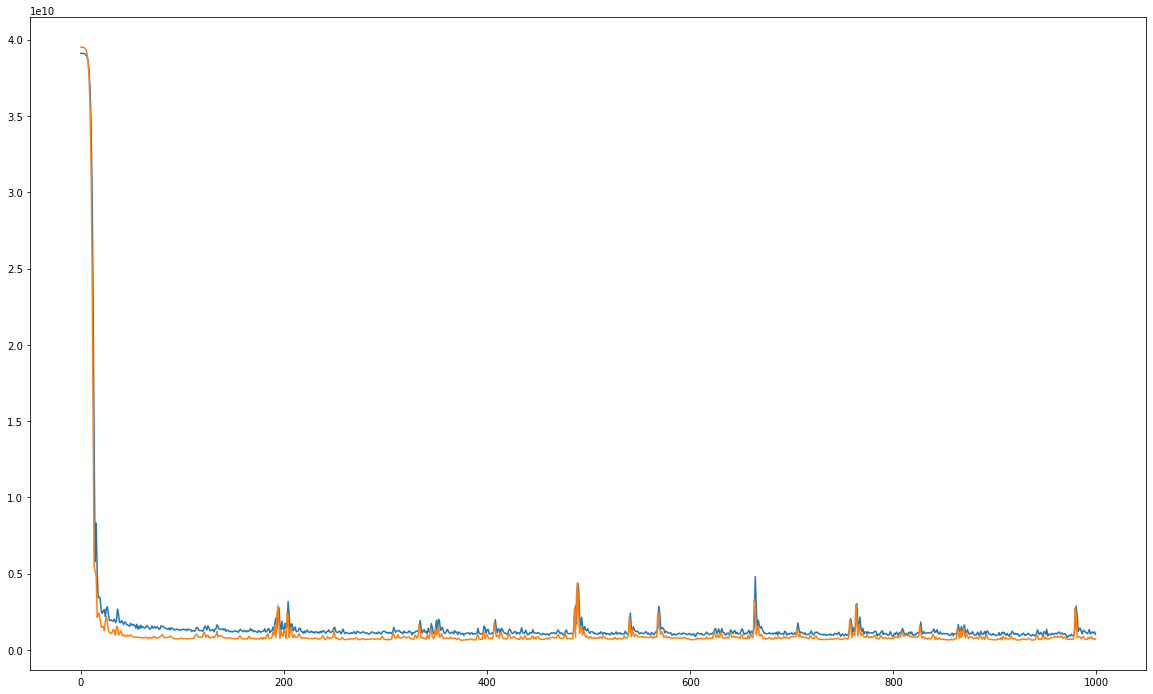

In [467]:
plt.figure(figsize = (20,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [468]:
pred = model.predict(X_test_ss)

In [469]:
from sklearn.metrics import r2_score

In [470]:
r2_score(y_train, model.predict(X_train_ss))

0.9414077841111688

In [471]:
r2_score(y_test, pred)

0.8805481882510211

In [472]:
np.sqrt(mean_squared_error(y_train, model.predict(X_train_ss)))

19250.133883133785

In [473]:
np.sqrt(mean_squared_error(y_test, model.predict(X_test_ss)))

27082.04346461276

### Not quite as good as Random Forests, but still not bad at all.